# Prediction diabetes readmission

## Business Understanding


I decided to work with this dataset since it represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. The integrity of this data could help me to solve a real-world problem using Data science.

 I’ll be using Machine Learning to predict whether a patient could be:
 
1. No readmissioned;
2. A readmission in less than 30 days (this situation is not good, because maybe
your treatment was not appropriate);
3. A readmission in more than 30 days (this one is not so good as well the last
one, however, the reason could be the state of the patient.

The analisys walks through the next steps:
 1. Data Understanding
 2. Data Exploration
 3. Cleaning
 4. Training Machine Learning Model
 5. Evaluating Machine Learning Model

## 1. Data Understanding

First, I'm going to start reading diabetes training data into a pandas dataframe called df_diabetes and importing the necessary dependecies needed in the analysis.

In [65]:
import numpy as np
import pandas as pd
import utils.columns_utils as cu
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

df_diabetes = pd.read_csv("./resource/diabetic_data.csv", index_col='encounter_id')

Then checking data, it has been read properly: First five rows:

In [66]:
df_diabetes.head(5)

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [67]:
num_rows = df_diabetes.shape[0]
num_col = df_diabetes.shape[1]
print ("Number of columns :{} and rows:{} ".format(num_col, num_rows))

Number of columns :49 and rows:101766 


### 1.1 Checking Nullabilty

In this step, I want to be sure the data is clean (has no null values, etc).

In [68]:
cu.get_info_cleaing_process(df_diabetes)
print(f"Quantity null values (Nan or None): {df_diabetes.isnull().sum().sum()}\n")
df_diabetes.info()


Columns missing values
Series([], dtype: int64)
Quantity null values (Nan or None): 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures    

Note that the data doesn't have some missing values (Nan, null or none) 
in the samples in the previous figure. However, there are a lot of question marks "?", but I’ll skip that for now.

### 1.2 Knowing columns data type (Object - Quantitative):

In [69]:

print("Object columns (Test):")
text_columns = cu.get_columns_type(df_diabetes.select_dtypes(include='object'))

print("Quantitative columns:")
quantitative_columns = cu.get_columns_type(df_diabetes.select_dtypes(exclude='object'))


Object columns (Test):
		 race
		 gender
		 age
		 weight
		 payer_code
		 medical_specialty
		 diag_1
		 diag_2
		 diag_3
		 max_glu_serum
		 A1Cresult
		 metformin
		 repaglinide
		 nateglinide
		 chlorpropamide
		 glimepiride
		 acetohexamide
		 glipizide
		 glyburide
		 tolbutamide
		 pioglitazone
		 rosiglitazone
		 acarbose
		 miglitol
		 troglitazone
		 tolazamide
		 examide
		 citoglipton
		 insulin
		 glyburide-metformin
		 glipizide-metformin
		 glimepiride-pioglitazone
		 metformin-rosiglitazone
		 metformin-pioglitazone
		 change
		 diabetesMed
		 readmitted
Quantitative columns:
		 patient_nbr
		 admission_type_id
		 discharge_disposition_id
		 admission_source_id
		 time_in_hospital
		 num_lab_procedures
		 num_procedures
		 num_medications
		 number_outpatient
		 number_emergency
		 number_inpatient
		 number_diagnoses



### 1.3 Categorical variables analysis


Using the above Object and quantitative columns,  I'm going to review all items in the list in order to select which features correspond to categorical variables.

In [70]:
p_var_cat = [ 'race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1',
		 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
		 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
         'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
		 'examide', 'citoglipton','insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
		 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
		 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
		 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
		 'number_inpatient', 'number_diagnoses']

df_diabetes[p_var_cat].astype('category')
print(df_diabetes[p_var_cat].nunique())

race                            6
gender                          3
age                            10
weight                         10
payer_code                     18
medical_specialty              73
diag_1                        717
diag_2                        749
diag_3                        790
max_glu_serum                   4
A1Cresult                       4
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  4
glimepiride                     4
acetohexamide                   2
glipizide                       4
glyburide                       4
tolbutamide                     2
pioglitazone                    4
rosiglitazone                   4
acarbose                        4
miglitol                        4
troglitazone                    2
tolazamide                      3
examide                         1
citoglipton                     1
insulin                         4
glyburide-metf

### Not Categorical Variables:

Remember Categorical variables must have a low number of categories .If the number of categories is big, the transformation could decrease the performance.The next feature list have a big number of categories per feature (>10), that is why, they aren't categorical variables.

```age, weight, payer_code, medical_specialty, Diag_1,Diag_2, Diag_3, patient_nbr, discharge_disposition_id, admission_source_id, time_in_hospital,num_lab_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses.```

 Even when the below features could be categorical variables, looking the accuracy once the prediction has been done using all the Diabetes medicines. They don't contribute nothing to the accurency score. In that order they aren't going to be take into account.
 

```'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
 'examide', 'citoglipton','insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
 'metformin-rosiglitazone', 'metformin-pioglitazone'```

###  Categorical Variables:

Once the categorical variable analysis process finished, I obtained the following list of Categorical Variables:

```'race', 'gender',  'change', 'diabetesMed', 'readmitted','admission_type_id','num_procedures'```

In [71]:
var_cat = [ 'race', 'gender', 'diabetesMed', 'readmitted', 'num_procedures',
		 'admission_type_id']

cu.distribution_by_category(var_cat,df_diabetes)


Distribution by category per feature(variable)

Category:race
                 counts    %
Caucasian         76099  0.7
AfricanAmerican   19210  0.2
?                  2273  0.0
Hispanic           2037  0.0
Other              1506  0.0
Asian               641  0.0
Category:gender
                 counts    %
Female            54708  0.5
Male              47055  0.5
Unknown/Invalid       3  0.0
Category:diabetesMed
     counts    %
Yes   78363  0.8
No    23403  0.2
Category:readmitted
     counts    %
NO    54864  0.5
>30   35545  0.3
<30   11357  0.1
Category:num_procedures
   counts    %
0   46652  0.5
1   20742  0.2
2   12717  0.1
3    9443  0.1
6    4954  0.0
4    4180  0.0
5    3078  0.0
Category:admission_type_id
   counts    %
1   53990  0.5
3   18869  0.2
2   18480  0.2
6    5291  0.1
5    4785  0.0
8     320  0.0
7      21  0.0
4      10  0.0


## 2. Data Exploration

The next step is explore the correlation of data and visualize it using a heatmap.But first, I'm going to change the data type of the targe variable: ```readmitted``` from object (Text) to Numeric (int64). I want to use the new feature/column: ```readmitted_num``` using the next categories No=0, >30=1, <30=2.

In [90]:
#readmitt convert N=0, >30=1, <30=2
df_diabetes ['readmitted_num'] = df_diabetes['readmitted'].str.slice(0, 1)
df_diabetes ['readmitted_num'] =  df_diabetes ['readmitted_num'].replace(['N'],0)
df_diabetes ['readmitted_num'] =  df_diabetes ['readmitted_num'].replace(['>'],1)
df_diabetes ['readmitted_num'] =  df_diabetes ['readmitted_num'].replace(['<'],2)

As we can see from the table and the below heatmap ```number_inpatient```,```number_emergency```,```number_diagnoses``` have significant correlation with the outcome/targe variable : readmitted_num

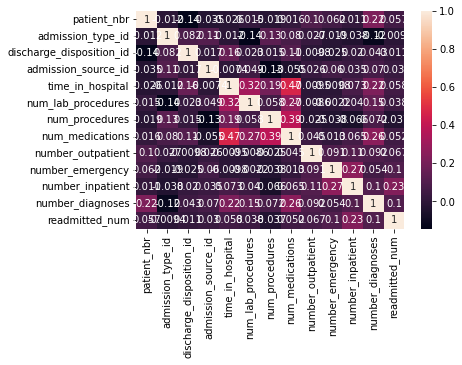

In [91]:
numeric_dtypes_corr = df_diabetes.corr()
sns.heatmap(numeric_dtypes_corr, annot=True)
plt.show()

Also notice the correlation between pairs of features, like time_in_hospital and num_medication, time_in_hospital and num_lab_procedures, or time_in_hospital and num_procedures, or time_in_hospital and num_medications, or num_lab_procedures and num_medications, or num_lab_procedures and num_procedures, or num_procedures and num_medications, or number_inpatient and number_outpatient, or discharge_disposition_id and time_in_hospital, or discharge_disposition_id and num_medications

In [92]:
print(numeric_dtypes_corr)

                          patient_nbr  admission_type_id  \
patient_nbr                  1.000000          -0.012412   
admission_type_id           -0.012412           1.000000   
discharge_disposition_id    -0.141315           0.081921   
admission_source_id         -0.035129           0.108711   
time_in_hospital            -0.025922          -0.012403   
num_lab_procedures           0.014957          -0.142429   
num_procedures              -0.019031           0.128789   
num_medications              0.015862           0.079812   
number_outpatient            0.102743           0.026707   
number_emergency             0.061520          -0.019491   
number_inpatient             0.011232          -0.038240   
number_diagnoses             0.219902          -0.118788   
readmitted_num               0.057031          -0.009421   

                          discharge_disposition_id  admission_source_id  \
patient_nbr                              -0.141315            -0.035129   
admission

As we can see from the below table, race, gender, diabetesMed and admission_type_id all have significant correlation with the outcome variable : readmitted_num

In [93]:
ct = pd.crosstab([df_diabetes['race'], df_diabetes['gender'], df_diabetes['diabetesMed']], df_diabetes['readmitted_num'],margins=True,  normalize='index')
print(ct)


readmitted_num                             0         1         2
race            gender diabetesMed                              
AfricanAmerican Female No           0.571747  0.325279  0.102974
                       Yes          0.529763  0.357048  0.113189
                Male   No           0.574913  0.313589  0.111498
                       Yes          0.539062  0.345833  0.115104
Asian           Female No           0.679487  0.282051  0.038462
                       Yes          0.633333  0.279167  0.087500
                Male   No           0.659091  0.181818  0.159091
                       Yes          0.646809  0.238298  0.114894
Caucasian       Female No           0.591028  0.316525  0.092447
                       Yes          0.497680  0.380345  0.121975
                Male   No           0.600369  0.303813  0.095818
                       Yes          0.525495  0.359477  0.115028
Hispanic        Female No           0.620301  0.296992  0.082707
                       Ye

<AxesSubplot:xlabel='readmitted_num', ylabel='race-gender-diabetesMed'>

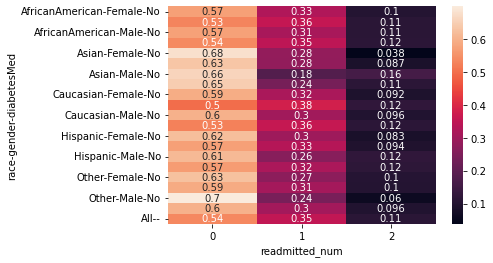

In [94]:
sns.heatmap(ct, annot=True)

In [95]:
pd.crosstab([df_diabetes.gender,df_diabetes.admission_type_id],[df_diabetes.diabetesMed, df_diabetes.readmitted],margins=True).style.background_gradient(cmap='pink_r')

### 3. Cleaning

1. Drop rows with question marks "?"

In [96]:

df_diabetes["gender"] = df_diabetes["gender"].replace("Unknown/Invalid", np.NaN)
df_diabetes.dropna(subset=["gender"], axis=0, inplace=True)

df_diabetes["race"] = df_diabetes["race"].replace("?", np.NaN)
df_diabetes.dropna(subset=["race"], axis=0, inplace=True)

cu.distribution_by_category(var_cat,df_diabetes)


Distribution by category per feature(variable)

Category:race
                 counts    %
Caucasian         76099  0.8
AfricanAmerican   19210  0.2
Hispanic           2037  0.0
Other              1505  0.0
Asian               641  0.0
Category:gender
        counts    %
Female   53575  0.5
Male     45917  0.5
Category:diabetesMed
     counts    %
Yes   76491  0.8
No    23001  0.2
Category:readmitted
     counts    %
NO    53316  0.5
>30   35007  0.4
<30   11169  0.1
Category:num_procedures
   counts    %
0   45500  0.5
1   20328  0.2
2   12488  0.1
3    9269  0.1
6    4825  0.0
4    4098  0.0
5    2984  0.0
Category:admission_type_id
   counts    %
1   52900  0.5
3   18507  0.2
2   17786  0.2
6    5225  0.1
5    4727  0.0
8     317  0.0
7      20  0.0
4      10  0.0


##  4. Training Machine Learning Model

I selected K Nearest Neighbor algorithm because is really simple, easy to understand and one of the topmost machine learning algorithms. This KNN Classifier needs the training set and the test set. 

 ### 4.1 Dataset preparation

To obtain those sets, I needed to split the data: training set size 70% and test set size 30%.

In [97]:
num_rows = df_diabetes.shape[0]
num_col = df_diabetes.shape[1]
print ("Number of columns :{} and rows:{} ".format(num_col, num_rows))

Number of columns :50 and rows:99492 


So, The 70% = 69645 and the 30% = 29847
The data set consists of record of 99492 patients in total. To train the model I will be using 69645 records, and  29847 records for testing.

In [98]:
df_diabetes_training = df_diabetes[:69646]
df_diabetes_test = df_diabetes[69646:]

The next step is grouping all features/variables with significant correlation with the outcome variable like:
  __```race, gender, diabetesMed, number_inpatient,number_emergency,number_diagnoses, and admission_type_id```__


And variables with correlation between them like:
__```time_in_hospital, num_medications, num_lab_procedures, num_procedures, number_inpatient, number_outpatient and discharge_disposition_id ```__


The union of these list of variables correspond to the variables that helps to predict the model:

In [99]:
[ 'race', 'gender', 'diabetesMed', 'number_inpatient', 'number_emergency', 'number_diagnoses', 'admission_type_id','time_in_hospital','num_medications','num_lab_procedures','num_procedures',  'number_outpatient', 'discharge_disposition_id', 'readmitted_num']

['race',
 'gender',
 'diabetesMed',
 'number_inpatient',
 'number_emergency',
 'number_diagnoses',
 'admission_type_id',
 'time_in_hospital',
 'num_medications',
 'num_lab_procedures',
 'num_procedures',
 'number_outpatient',
 'discharge_disposition_id',
 'readmitted_num']

Using __get_dummies__ Convert categorical variable into dummy/indicator variables (1/0).

In [100]:
df_diabetes_target_prediction_variables = pd.get_dummies(df_diabetes_training[[ 'patient_nbr', 'race', 'gender', 'diabetesMed', 'number_inpatient', 'number_emergency', 'number_diagnoses', 'admission_type_id',
		 'time_in_hospital','num_medications','num_lab_procedures','num_procedures',  'number_outpatient', 'discharge_disposition_id', 'readmitted_num']])
print(df_diabetes_target_prediction_variables.head())

              patient_nbr  number_inpatient  number_emergency  \
encounter_id                                                    
2278392           8222157                 0                 0   
149190           55629189                 0                 0   
64410            86047875                 1                 0   
500364           82442376                 0                 0   
16680            42519267                 0                 0   

              number_diagnoses  admission_type_id  time_in_hospital  \
encounter_id                                                          
2278392                      1                  6                 1   
149190                       9                  1                 3   
64410                        6                  1                 2   
500364                       7                  1                 2   
16680                        5                  1                 1   

              num_medications  num_lab_procedu

The next step is assing the target variable into a new variable 'x' and delete it from the prediction variable list. This target variable is the one I want to predict: readmitted

In [101]:
x = df_diabetes_target_prediction_variables
y = df_diabetes_target_prediction_variables['readmitted_num']

x.drop(['readmitted_num'],axis=1, inplace=True)

### 4.1 Instantiate, Fit and predict

In [102]:
# Learning process
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state = 0)
lm_model = KNeighborsClassifier(n_neighbors=3)
# Fit the k-nearest neighbors classifier from the training dataset.
lm_model.fit(X_train, y_train)
# Predict
y_pred = lm_model.predict(X_test)
print(f"Accuracy: {np.round(metrics.accuracy_score(y_test, y_pred), 2)}")


Accuracy: 0.51


In [103]:
df_diabetes_test_t = pd.get_dummies(df_diabetes_test[[ 'patient_nbr','race', 'gender', 'diabetesMed', 'number_inpatient', 'number_emergency', 'number_diagnoses', 'admission_type_id',
		 'time_in_hospital','num_medications','num_lab_procedures','num_procedures',  'number_outpatient', 'discharge_disposition_id']])
print(df_diabetes_test_t.head())
# Generate test predictions
preds_test = lm_model.predict(df_diabetes_test_t)


# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': df_diabetes_test_t.patient_nbr,
                       'readmitted': preds_test})
output.to_csv('readmitted_T_KNN_v2.csv', index=False)

              patient_nbr  number_inpatient  number_emergency  \
encounter_id                                                    
204940446        90002340                 0                 0   
204944922         6039630                 0                 0   
204970092       109877742                 0                 0   
204971226        56980809                 3                 0   
204976278        85399461                 2                 0   

              number_diagnoses  admission_type_id  time_in_hospital  \
encounter_id                                                          
204940446                    9                  1                 6   
204944922                    5                  1                 2   
204970092                    7                  2                 6   
204971226                    9                  1                 1   
204976278                    9                  3                 7   

              num_medications  num_lab_procedu

The prediction of the  test dataset were saved in readmitted_T_KNN_v2.cs file.